In [1]:
from qaravan.core import *
from qaravan.tensorQ import *
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [16]:
gate_list = [H(0), RZ(0, np.pi/4), H(0)]
circ = Circuit(gate_list, 2)

mat = circ.to_matrix()
init_sv = np.array([1, 0, 0, 0])
final_sv = mat @ init_sv
dm = np.outer(final_sv, final_sv.conj())

op = (np.kron(pauli_Z, pauli_I) + np.kron(pauli_I, pauli_Z))/(2*np.sqrt(2))
noiseless_exp = np.trace(op @ dm).real
noiseless_exp

np.float64(0.6035533905932735)

In [32]:
strength = 0.3
coeffs = np.random.rand(2) * strength
strings = ['xx', 'yx']
channel = PauliLindbladNoise(strings, coeffs)
sim = DensityMatrixSim(circ=copy.deepcopy(circ), nm=channel)
sim.run(progress_bar=False)
dm = sim.get_density_matrix()
noisy_exp = np.trace(op @ dm).real
noisy_exp

np.float64(0.18410041463149632)

In [33]:
sim = TrajectorySim(circ=copy.deepcopy(circ), nm=channel)
mag_samples = [sim.expectation_sample(op) for _ in tqdm(range(100000))]

reps = 100
sample_size_opts = np.logspace(1, 4, num=10).astype(int)

noisy_mag_means = []
noisy_mag_stds = []
noisy_err_means = []
noisy_err_stds = []
for sample_size in sample_size_opts: 
    mag_errs = []
    mag_means = []
    for _ in tqdm(range(reps)):
        subsample = np.random.choice(mag_samples, size=sample_size, replace=False)
        mag_means.append(np.mean(subsample))
        mag_errs.append(np.abs(np.mean(subsample) - noisy_exp))

    noisy_mag_means.append(np.mean(mag_means))
    noisy_mag_stds.append(np.std(mag_means))
    noisy_err_means.append(np.mean(mag_errs))
    noisy_err_stds.append(np.std(mag_errs))

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [34]:
sim = PECSim(circ=copy.deepcopy(circ), nm=channel)
mag_samples = [sim.expectation_sample(op) for _ in tqdm(range(100000))]

reps = 100
sample_size_opts = np.logspace(1, 4, num=10).astype(int)

corrected_mag_means = []
corrected_mag_stds = []
corrected_err_means = []
corrected_err_stds = []
for sample_size in sample_size_opts: 
    mag_errs = []
    mag_means = []
    for _ in tqdm(range(reps)):
        subsample = np.random.choice(mag_samples, size=sample_size, replace=False)
        mag_means.append(np.mean(subsample))
        mag_errs.append(np.abs(np.mean(subsample) - noiseless_exp))

    corrected_mag_means.append(np.mean(mag_means))
    corrected_mag_stds.append(np.std(mag_means))
    corrected_err_means.append(np.mean(mag_errs))
    corrected_err_stds.append(np.std(mag_errs))

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

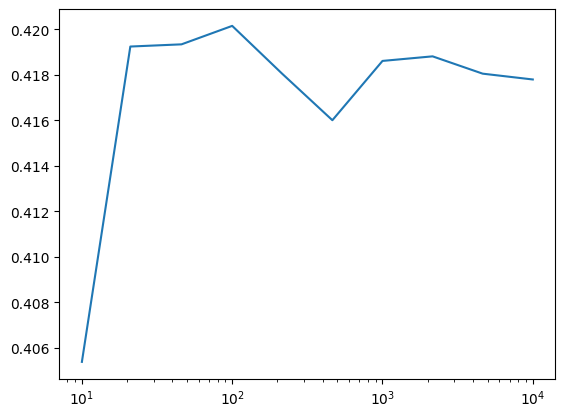

In [42]:
new_errs = [np.abs(nm-noiseless_exp) for nm in noisy_mag_means]
plt.plot(sample_size_opts, new_errs)
plt.xscale('log')

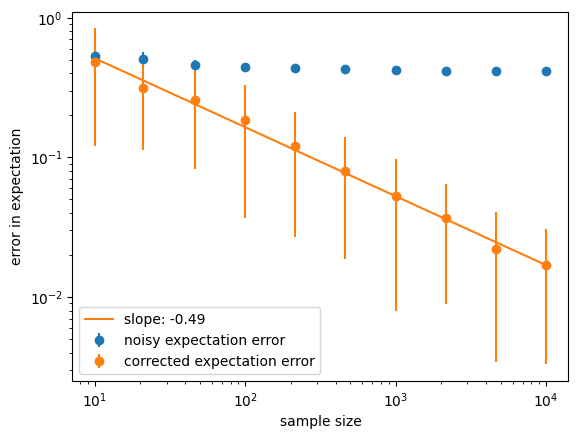

In [45]:
log_corrected_errs = np.log(corrected_err_means)
log_errs = np.log(np.array(noisy_err_means) + 0.41)
noisy_err_means_new = np.array(noisy_err_means) + 0.41  # Adjusting for numerical stability in log scale
log_sizes = np.log(sample_size_opts)

fit_corrected = np.polyfit(log_sizes, log_corrected_errs, 1)
#fit_noisy = np.polyfit(log_sizes, log_errs, 1)
fit_corrected_line = np.polyval(fit_corrected, log_sizes)
#fit_noisy_line = np.polyval(fit_noisy, log_sizes)

plt.errorbar(sample_size_opts, noisy_err_means_new, yerr=noisy_err_stds, fmt='o', label='noisy expectation error', color='C0')
plt.errorbar(sample_size_opts, corrected_err_means, yerr=corrected_err_stds, fmt='o', label='corrected expectation error', color='C1')
plt.plot(sample_size_opts, np.exp(fit_corrected_line), label=f"slope: {fit_corrected[0]:.2f}", color='C1')
#plt.plot(sample_size_opts, np.exp(fit_noisy_line), label=f"slope: {fit_noisy[0]:.2f}", color='C0')

plt.xscale('log')
plt.xlabel('sample size')
plt.ylabel('error in expectation')
plt.yscale('log')
plt.legend()

In [36]:
channel.gamma**3, corrected_err_means[0]/noisy_err_means[0]

(np.float64(4.32726536635317), np.float64(3.8861348656223123))

In [ ]:
blue: 

|| without PEC sampled expectation - Tr(rho_noisy * magnetization) || 

orange: 

|| PEC sampled expectation - <\psi| M \psi> || 


# Old

In [10]:
mag_samples = []
for s in tqdm(range(100000)):
    noise_layer = pauli_string_to_gates(channel.sample_string())
    if len(noise_layer) == 0:
        mag_samples.append(final_sv.conj().T @ op @ final_sv)
    else: 
        n_circ = Circuit(noise_layer, 2)
        sim = StatevectorSim(n_circ, init_state=final_sv)
        sv = sim.run(progress_bar=False).reshape(2**2)
        mag_samples.append(sv.conj().T @ op @ sv)

reps = 100
sample_size_opts = np.logspace(1, 4, num=10).astype(int)

noisy_mag_means = []
noisy_mag_stds = []
noisy_err_means = []
noisy_err_stds = []
for sample_size in sample_size_opts: 
    mag_errs = []
    mag_means = []
    for _ in tqdm(range(reps)):
        subsample = np.random.choice(mag_samples, size=sample_size, replace=False)
        mag_means.append(np.mean(subsample))
        mag_errs.append(np.abs(np.mean(subsample) - noisy_exp))

    noisy_mag_means.append(np.mean(mag_means))
    noisy_mag_stds.append(np.std(mag_means))
    noisy_err_means.append(np.mean(mag_errs))
    noisy_err_stds.append(np.std(mag_errs))

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [141]:
gamma = np.exp(2*sum(channel.lindblad_coefficients))
mag_samples = []
for s in tqdm(range(500000)):
    noise_layer = pauli_string_to_gates(channel.sample_string())
    correction_layer = pauli_string_to_gates(channel.sample_string())
    new_layer = noise_layer + correction_layer
    pre_fac = gamma * (-1)**(len(correction_layer) != 0)
    if len(new_layer) == 0:
        m = final_sv.conj().T @ op @ final_sv
    else: 
        n_circ = Circuit(new_layer, 2)
        sim = StatevectorSim(n_circ, init_state=final_sv)
        sv = sim.run(progress_bar=False).reshape(2**2)
        m = sv.conj().T @ op @ sv

    mag_samples.append(pre_fac * m)

reps = 100
sample_size_opts = np.logspace(1, 4, num=10).astype(int)

corrected_mag_means = []
corrected_mag_stds = []
corrected_err_means = []
corrected_err_stds = []
for sample_size in sample_size_opts: 
    mag_errs = []
    mag_means = []
    for _ in tqdm(range(reps)):
        subsample = np.random.choice(mag_samples, size=sample_size, replace=False)
        mag_means.append(np.mean(subsample))
        mag_errs.append(np.abs(np.mean(subsample) - noiseless_exp))

    corrected_mag_means.append(np.mean(mag_means))
    corrected_mag_stds.append(np.std(mag_means))
    corrected_err_means.append(np.mean(mag_errs))
    corrected_err_stds.append(np.std(mag_errs))

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

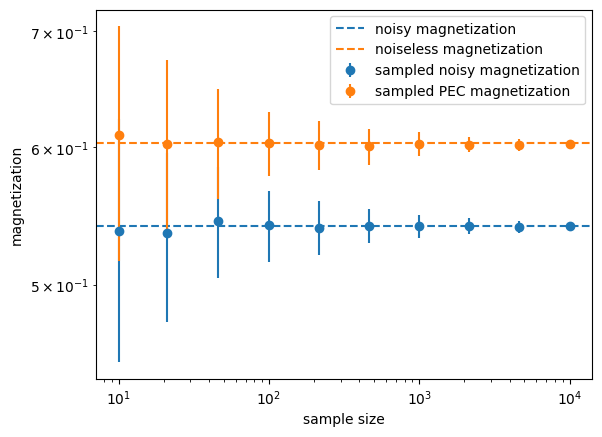

In [142]:
plt.axhline(y=noisy_exp, linestyle='--', label='noisy magnetization', color="C0")
plt.errorbar(sample_size_opts, np.abs(noisy_mag_means), yerr=noisy_mag_stds, fmt='o', label='sampled noisy magnetization', color="C0")  
plt.axhline(y=noiseless_exp, linestyle='--', label='noiseless magnetization', color="C1")
plt.errorbar(sample_size_opts, np.abs(corrected_mag_means), yerr=corrected_mag_stds, fmt='o', label='sampled PEC magnetization', color="C1")
plt.yscale('log')
plt.xscale('log')
plt.xlabel('sample size')
plt.ylabel('magnetization')
plt.legend()

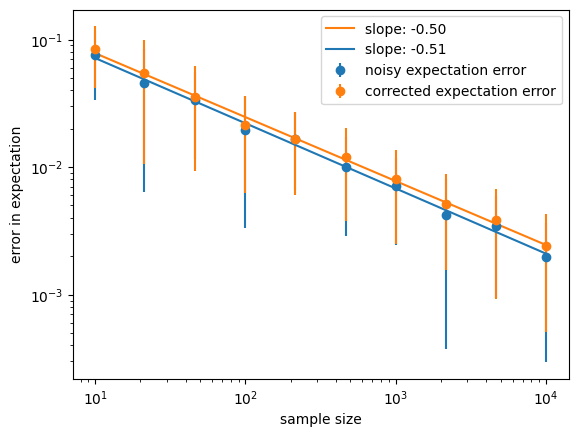

In [143]:
log_corrected_errs = np.log(corrected_err_means)
log_errs = np.log(noisy_err_means)
log_sizes = np.log(sample_size_opts)

fit_corrected = np.polyfit(log_sizes, log_corrected_errs, 1)
fit_noisy = np.polyfit(log_sizes, log_errs, 1)
fit_corrected_line = np.polyval(fit_corrected, log_sizes)
fit_noisy_line = np.polyval(fit_noisy, log_sizes)

plt.errorbar(sample_size_opts, noisy_err_means, yerr=noisy_err_stds, fmt='o', label='noisy expectation error', color='C0')
plt.errorbar(sample_size_opts, corrected_err_means, yerr=corrected_err_stds, fmt='o', label='corrected expectation error', color='C1')
plt.plot(sample_size_opts, np.exp(fit_corrected_line), label=f"slope: {fit_corrected[0]:.2f}", color='C1')
plt.plot(sample_size_opts, np.exp(fit_noisy_line), label=f"slope: {fit_noisy[0]:.2f}", color='C0')

plt.xscale('log')
plt.xlabel('sample size')
plt.ylabel('error in expectation')
plt.yscale('log')
plt.legend()

In [144]:
gamma, corrected_err_means[0]/noisy_err_means[0] 

(np.float64(1.1161699888966237), np.float64(1.12201788249114))

In [34]:
strength = 0.3
coeffs = np.random.rand(2) * strength
strings = ['xx', 'yx']
channel = PauliLindbladNoise(strings, coeffs)
sim = DensityMatrixSim(circ=copy.deepcopy(circ), nm=channel)
sim.run(progress_bar=False)
dm = sim.get_density_matrix()
noisy_exp = np.trace(op @ dm).real
noisy_exp

np.float64(0.046997005094357225)

In [35]:
mag_samples = []
for s in tqdm(range(100000)):
    noise_layer = pauli_string_to_gates(channel.sample_string())
    if len(noise_layer) == 0:
        mag_samples.append(final_sv.conj().T @ op @ final_sv)
    else: 
        n_circ = Circuit(noise_layer, 2)
        sim = StatevectorSim(n_circ, init_state=final_sv)
        sv = sim.run(progress_bar=False).reshape(2**2)
        mag_samples.append(sv.conj().T @ op @ sv)

reps = 100
sample_size_opts = np.logspace(1, 4, num=10).astype(int)

noisy_mag_means = []
noisy_mag_stds = []
noisy_err_means = []
noisy_err_stds = []
for sample_size in sample_size_opts: 
    mag_errs = []
    mag_means = []
    for _ in tqdm(range(reps)):
        subsample = np.random.choice(mag_samples, size=sample_size, replace=False)
        mag_means.append(np.mean(subsample))
        mag_errs.append(np.abs(np.mean(subsample) - noisy_exp))

    noisy_mag_means.append(np.mean(mag_means))
    noisy_mag_stds.append(np.std(mag_means))
    noisy_err_means.append(np.mean(mag_errs))
    noisy_err_stds.append(np.std(mag_errs))

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]